### Import libraries

In [1]:
import os
import sys
from datetime import datetime
import re
import yaml
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF
import h5py as h5

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.preprocesser import *
from src.utils.optostim import *

### Set folder locations for analysed behaviour and keypoint data 

In [2]:
# folder locations for analysed data
Experiment = "DLS_GtACR_opto-inhibition"
Animals = ["SP108", "SP110", "SP112", "SP148", "SP149", "SP150", "SP151", "SP152", "SP153"] ## "SP150"
Group = ["DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR"]
Camera_Folder = "/mnt/ceph/projects/sequences/SP_FlyCap"
data_Folder = "/mnt/ceph/projects/sequences/analysed_data"
deeplabcut_folder = "/mnt/ceph/projects/sequences/SP_FlyCap"

# output folder is in data_folder/analysed_data/behaviour_output/Experiment
Output_Folder = os.path.join(data_Folder, "behaviour_output", Experiment)

In [3]:
# save path for figures
save_folder = os.path.join(Output_Folder, "plots")
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print("Created folder: ", save_folder)
else:
    print("Folder already exists: ", save_folder)

Folder already exists:  /mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/plots


In [4]:
test_animal = "SP153"

### Load files from deeplabcut_folder + test_animal


In [5]:

path_to_dlc = os.path.join(deeplabcut_folder, test_animal, "predictions")

print(f'path_to_dlc: {path_to_dlc}')

# list all h5 files in the folder
h5_files = [f for f in os.listdir(path_to_dlc) if f.endswith('.h5')]

print(h5_files)

path_to_dlc: /mnt/ceph/projects/sequences/SP_FlyCap/SP153/predictions
['camera12024-01-29T12_26_56DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-02T13_11_53DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-16T12_10_14DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-05T11_40_32DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-02-01T12_27_56DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-10T12_42_02DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-20T13_01_04DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12023-12-29T12_30_37DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-12T12_43_07DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-09T12_37_00DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-08T11_44_14DL

In [6]:
# write a function to read the dates of the video from the h5 filenames (can be one name or a list of names)
# e.g. camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5 is recorded on 2024-02-02
import re

def get_date_from_h5(h5_filenames):
    """Extracts the recording date from h5 filenames in the format
       camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5

    Args:
        h5_filenames: A single h5 filename (str) or a list of filenames (list).

    Returns:
        If a single filename is provided: The date as a string in the format YYYY-MM-DD
        If a list of filenames is provided: A list of corresponding dates.  
    """

    date_pattern = r"\d{4}-\d{2}-\d{2}"  # Pattern for YYYY-MM-DD

    if isinstance(h5_filenames, str):  # Handle a single filename
        match = re.search(date_pattern, h5_filenames)
        if match:
            return match.group(0)
        else:
            return None  # Date not found in filename

    elif isinstance(h5_filenames, list):  # Handle a list of filenames
        dates = []
        for filename in h5_filenames:
            match = re.search(date_pattern, filename)
            if match:
                dates.append(match.group(0))
            else:
                dates.append(None)  # Indicate date not found
        return dates

    else:
        raise TypeError("Input must be a string or a list of strings.")


    
# h5_filename = 'camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5'

# print(get_date_from_h5(h5_filename))


In [7]:
test_date = datetime.datetime(2024, 1, 4)
print(test_date)
print(get_date_from_h5(h5_files))
# get the h5 file for the test date
h5_file = [f for f in h5_files if get_date_from_h5(f) == test_date.strftime("%Y-%m-%d")][0]

print(h5_file)


2024-01-04 00:00:00
['2024-01-29', '2024-01-02', '2024-01-16', '2024-01-05', '2024-02-01', '2024-01-10', '2024-01-20', '2023-12-29', '2024-01-12', '2024-01-09', '2024-01-08', '2024-02-05', '2024-01-06', '2024-01-03', '2024-01-25', '2024-01-23', '2024-02-02', '2024-01-26', '2024-01-13', '2024-01-07', '2024-01-24', '2023-12-30', '2024-01-18', '2024-01-31', '2024-01-30', '2024-01-11', '2024-01-15', '2024-01-21', '2024-01-04', '2024-01-22', '2024-01-28', '2024-02-03', '2024-01-14', '2024-01-01', '2024-02-04', '2024-02-06', '2024-01-17', '2024-01-19']
camera12024-01-04T12_59_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


In [8]:
# read the h5 file
h5_path = os.path.join(path_to_dlc, h5_file)
print(h5_path)

# read the h5 file into a pandas dataframe

keypoints_df = pd.read_hdf(h5_path)
keypoints_df.head()


/mnt/ceph/projects/sequences/SP_FlyCap/SP153/predictions/camera12024-01-04T12_59_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


scorer    DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000  \
bodyparts                                                      nose   
coords                                                            x   
0                                                 578.301636          
1                                                 576.672424          
2                                                 577.094849          
3                                                 580.917664          
4                                                 582.972412          

scorer                                                               \
bodyparts                           left_ear                          
coords              y likelihood           x           y likelihood   
0          464.669983   0.975599  514.659485  460.311096   0.788724   
1          464.643402   0.979968  529.438721  453.496643   0.751821   
2          465.725037   0.985446  523.658508  454.758942   0.759997   
3          466.760254   0.990648  513.732788  460.524078   0.847170   
4          464.790100   0.983712  513.098389  460.043213   0.769473   

scorer                                                       ...  \
bodyparts   right_ear                        cervical_spine  ...   
coords              x           y likelihood              x  ...   
0          586.452454  524.025879   0.977400     551.241272  ...   
1          587.487488  522.901855   0.983055     550.571777  ...   
2          586.953308  522.742737   0.986593     548.458801  ...   
3          585.734131  523.667847   0.988448     546.912964  ...   
4          585.649536  523.134399   0.987255     547.413452  ...   

scorer                                                                    \
bodyparts thorasic_spine lumbar_spine                          tail_base   
coords        likelihood            x           y likelihood           x   
0               0.982345   503.629364  571.032837   0.984747  513.771362   
1               0.978609   504.408783  572.043762   0.984862  513.487122   
2               0.976207   504.184418  573.422852   0.988225  513.798401   
3               0.959744   503.302216  574.368225   0.988134  513.482544   
4               0.960179   503.090363  573.595093   0.986297  512.645203   

scorer                                                               
bodyparts                           tail_tip                         
coords              y likelihood           x           y likelihood  
0          632.158386   0.999171  753.675415  695.006470   0.997966  
1          632.704346   0.998878  753.520874  694.997559   0.998007  
2          632.738770   0.999229  753.661621  695.452942   0.997874  
3          632.806885   0.999248  753.524963  695.374939   0.997906  
4          632.207825   0.998812  753.595520  694.823547   0.998090  

[5 rows x 24 columns]

In [9]:
# make a copy of the dataframe
test_df = keypoints_df.copy()

# remove the first level of the multiindex
test_df.columns = test_df.columns.droplevel(0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314203 entries, 0 to 314202
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   (nose, x)                     314203 non-null  float64
 1   (nose, y)                     314203 non-null  float64
 2   (nose, likelihood)            314203 non-null  float64
 3   (left_ear, x)                 314203 non-null  float64
 4   (left_ear, y)                 314203 non-null  float64
 5   (left_ear, likelihood)        314203 non-null  float64
 6   (right_ear, x)                314203 non-null  float64
 7   (right_ear, y)                314203 non-null  float64
 8   (right_ear, likelihood)       314203 non-null  float64
 9   (cervical_spine, x)           314203 non-null  float64
 10  (cervical_spine, y)           314203 non-null  float64
 11  (cervical_spine, likelihood)  314203 non-null  float64
 12  (thorasic_spine, x)           314203 non-null  fl

In [10]:
print(test_df.columns)

MultiIndex([(          'nose',          'x'),
            (          'nose',          'y'),
            (          'nose', 'likelihood'),
            (      'left_ear',          'x'),
            (      'left_ear',          'y'),
            (      'left_ear', 'likelihood'),
            (     'right_ear',          'x'),
            (     'right_ear',          'y'),
            (     'right_ear', 'likelihood'),
            ('cervical_spine',          'x'),
            ('cervical_spine',          'y'),
            ('cervical_spine', 'likelihood'),
            ('thorasic_spine',          'x'),
            ('thorasic_spine',          'y'),
            ('thorasic_spine', 'likelihood'),
            (  'lumbar_spine',          'x'),
            (  'lumbar_spine',          'y'),
            (  'lumbar_spine', 'likelihood'),
            (     'tail_base',          'x'),
            (     'tail_base',          'y'),
            (     'tail_base', 'likelihood'),
            (      'tail_tip',    

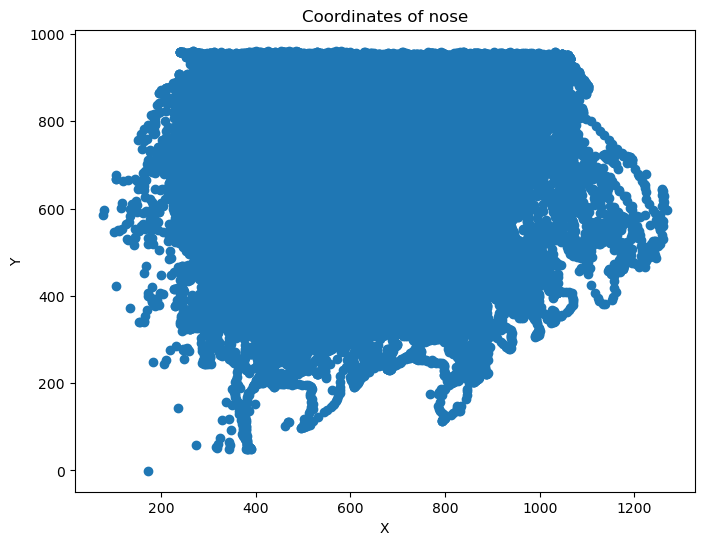

In [11]:
body_part = 'nose'

x_data = test_df[body_part, 'x']
y_data = test_df[body_part, 'y']

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(x_data, y_data)
plt.title(f'Coordinates of {body_part}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
# now loop through all Animals and concat the dataframes to create allsessions_DF

for i, current_animal in enumerate(Animals):
    print(current_animal)
    all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
    print(all_sessions_file_name)
    current_DF = pd.read_csv(all_sessions_file_name)
    if i == 0:
        allsessions_DF = current_DF
    else:
        allsessions_DF = pd.concat([allsessions_DF, current_DF], axis=0)

allsessions_DF.head()

SP108
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP108/SP108_transition_data_all_sessions.csv
SP110
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP110/SP110_transition_data_all_sessions.csv
SP112
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP112/SP112_transition_data_all_sessions.csv
SP148
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP148/SP148_transition_data_all_sessions.csv
SP149
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP149/SP149_transition_data_all_sessions.csv
SP150
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP150/SP150_transition_data_all_sessions.csv
SP151
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP151/SP151_transition_data_all_sessions.csv
SP152
/mnt/ceph/projects/sequences/analys

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
0,0,1,33,3,3,252.4712,252.4845,252.4927,254.1755,0.0082,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
1,1,1,37,3,7,252.4927,254.1755,319.3230,320.5142,65.1475,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
2,2,1,73,7,3,319.3230,320.5142,321.0197,321.0275,0.5055,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
3,3,1,33,3,3,321.0197,321.0275,321.0635,321.1840,0.0360,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
4,4,1,37,3,7,321.0635,321.1840,328.9522,330.1291,7.7682,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control


In [13]:
# get session settings loop through all Animals and concat the dataframes to create session_settings_DF
# append name of current animal to the session_settings_DF
# ignore .DS_Store files

for i, current_animal in enumerate(Animals):
    print(current_animal)
    current_DF = get_session_details(Output_Folder, current_animal)
    current_DF['Animal'] = current_animal
    if i == 0:
        session_details_DF = current_DF
    else:
        session_details_DF = pd.concat([session_details_DF, current_DF], axis=0)

session_details_DF.head()

SP108
SP110
SP112
SP148
SP149
SP150
SP151
SP152
SP153


,session_id,session,date,file_number,day,opto_session,stim_port,opto_chance,pulse_duration,pulse_interval,train_duration,train_delay,variable_train_delay,mu_variable_delay,sigma_variable_delay,lower_bound_variableDelay,upper_bound_variableDelay,experiment_type,Animal
0,0,00_20230421_104635_Fri,2023-04-21,104635,Fri,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
1,1,01_20230422_142310_Sat,2023-04-22,142310,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
2,2,02_20230422_142611_Sat,2023-04-22,142611,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
3,3,03_20230423_181053_Sun,2023-04-23,181053,Sun,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
4,4,04_20230424_110840_Mon,2023-04-24,110840,Mon,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108


In [14]:
# get the behaviour data for the test animal on test_date

test_behaviour_df = allsessions_DF[(allsessions_DF['animal_id'] == test_animal) & (allsessions_DF['date'] == test_date.strftime("%Y-%m-%d"))]
test_behaviour_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86647,0,1,63,6,3,23.5890,24.2442,24.6467,24.6904,0.4025,...,40.7515,41.4067,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86648,1,1,33,3,3,24.6467,24.6904,24.8570,24.9509,0.1666,...,41.8092,41.8529,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86649,2,1,37,3,7,24.8570,24.9509,25.2833,25.4314,0.3324,...,42.0195,42.1134,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86650,3,1,73,7,3,25.2833,25.4314,26.1900,26.2349,0.7586,...,42.4458,42.5939,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86651,4,1,32,3,2,26.1900,26.2349,26.4395,26.5836,0.2046,...,43.3525,43.3974,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control


In [15]:
# get all non-stimulated trials when test_behaviour_df['opto_condition is not 1
nonstim_df = test_behaviour_df[test_behaviour_df['opto_condition'] != 1]
nonstim_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86670,23,3,22,2,2,39.0490,39.1383,47.7545,47.9404,8.6162,...,56.212000,56.301300,56.212000,61.592500,11231,29,2024-01-04,Thu,SP153,Control
86678,31,5,21,2,1,54.0132,54.0904,54.4565,54.5389,0.3661,...,71.170625,71.247825,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86679,32,5,16,1,6,54.4565,54.5389,54.8337,54.8956,0.2948,...,71.613925,71.696325,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86680,33,5,63,6,3,54.8337,54.8956,55.4067,55.4606,0.5111,...,71.991125,72.053025,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control
86681,34,5,37,3,7,55.4067,55.4606,55.7002,57.8948,0.2396,...,72.564125,72.618025,71.170625,73.252875,11233,29,2024-01-04,Thu,SP153,Control


In [16]:
stim_df = test_behaviour_df[test_behaviour_df['opto_condition'] == 1]
stim_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
86647,0,1,63,6,3,23.5890,24.2442,24.6467,24.6904,0.4025,...,40.7515,41.4067,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86648,1,1,33,3,3,24.6467,24.6904,24.8570,24.9509,0.1666,...,41.8092,41.8529,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86649,2,1,37,3,7,24.8570,24.9509,25.2833,25.4314,0.3324,...,42.0195,42.1134,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86650,3,1,73,7,3,25.2833,25.4314,26.1900,26.2349,0.7586,...,42.4458,42.5939,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control
86651,4,1,32,3,2,26.1900,26.2349,26.4395,26.5836,0.2046,...,43.3525,43.3974,43.602,49.182375,11229,29,2024-01-04,Thu,SP153,Control


In [64]:
# get a random trail id from nonstim_df

trial_id = 62
# print(trial_id)

trial_df = nonstim_df[nonstim_df['trial_id'] == trial_id]
trial_df

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
87081,434,62,22,2,2,357.0053,357.0054,357.0055,357.1162,0.0001,...,374.175875,374.175975,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control
87082,435,62,21,2,1,357.0055,357.1162,357.4220,357.4803,0.3058,...,374.176075,374.286775,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control
87083,436,62,16,1,6,357.4220,357.4803,357.7459,357.7737,0.2656,...,374.592575,374.650875,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control
87084,437,62,63,6,3,357.7459,357.7737,358.1420,358.1930,0.3683,...,374.916475,374.944275,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control
87085,438,62,37,3,7,358.1420,358.1930,358.4176,360.7865,0.2246,...,375.312575,375.363575,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control
87086,439,62,72,7,2,358.4176,360.7865,361.1558,361.2910,0.3693,...,375.588175,377.957075,374.175875,375.9915,11290,29,2024-01-04,Thu,SP153,Control


In [65]:
camera_start = trial_df['camera_trial_start_times'].values[0]
camera_end = trial_df['camera_trial_end_times'].values[0]

next_trial_camera_start = test_behaviour_df[test_behaviour_df['trial_id'] == trial_id + 1]['camera_trial_start_times'].values[0]

print(camera_start, camera_end)
print(next_trial_camera_start)

374.175875 375.9915
378.323625


In [66]:
# now the aim is to exctract the frames that correspond to the trial from the video
# convert frmae numbers to numpy array
# row numbers of test_df that correspond to the frame numbers

frame_numbers = test_df.index.get_level_values(0).to_numpy()



In [67]:
# load files from timestamps folder inside Output_Folder+current_animal+deeplabcut_folder

timestamps_folder = os.path.join(deeplabcut_folder, test_animal)
#check if the folder exists
if not os.path.exists(timestamps_folder):
    print(f"Folder does not exist: {timestamps_folder}")
elif os.path.exists(timestamps_folder):
    print(f"Folder exists: {timestamps_folder}")

# list all files in the folder
timestamps_files = [f for f in os.listdir(timestamps_folder) if f.endswith('.csv')]
print(timestamps_files)

Folder exists: /mnt/ceph/projects/sequences/SP_FlyCap/SP153
['stamps2024-01-24T15_30_16.csv', 'stamps2024-01-08T11_44_14.csv', 'stamps2024-01-13T13_19_19.csv', 'stamps2024-01-22T13_40_05.csv', 'stamps2024-01-15T12_50_30.csv', 'stamps2024-02-02T12_19_31.csv', 'stamps2024-01-01T13_02_40.csv', 'stamps2024-01-19T12_58_41.csv', 'stamps2024-02-04T13_43_27.csv', 'stamps2024-01-31T11_58_22.csv', 'stamps2024-01-17T13_16_43.csv', 'stamps2024-01-09T12_36_59.csv', 'stamps2024-01-10T12_42_02.csv', 'stamps2024-02-06T13_04_00.csv', 'stamps2024-01-12T12_43_06.csv', 'stamps2023-12-30T13_21_19.csv', 'stamps2024-02-03T13_21_08.csv', 'stamps2024-01-02T13_11_52.csv', 'stamps2024-01-20T13_01_04.csv', 'stamps2024-01-26T14_03_37.csv', 'stamps2024-01-28T14_29_14.csv', 'stamps2023-12-29T12_30_37.csv', 'stamps2024-01-03T13_03_34.csv', 'stamps2024-01-04T12_59_31.csv', 'stamps2024-01-21T12_08_36.csv', 'stamps2024-01-16T12_10_14.csv', 'stamps2024-01-29T12_26_56.csv', 'stamps2024-01-23T12_01_39.csv', 'stamps2024-01-

In [68]:
# date of the session
query_date = trial_df['date'].values[0]
# query_date = '2024-01-29'
print(query_date)
print(type(query_date))
def get_timestamps_filename(timestamps_files, date):
    date_pattern = r"stamps" + date + r"T\d{2}_\d{2}_\d{2}\.csv"  
    for filename in timestamps_files:
        match = re.match(date_pattern, filename)
        if match:
            return match.group(0)  # Return the full matching filename

    return None  # No match found

timestamps_file = get_timestamps_filename(timestamps_files, query_date) 
print(timestamps_file)

2024-01-04
<class 'str'>
stamps2024-01-04T12_59_31.csv


In [69]:
# load the timestamps file
timestamps_path = os.path.join(timestamps_folder, timestamps_file)

timestamps = pd.read_csv(timestamps_path, delimiter=' ', header=None)
timestamps.head()

,0,1,2,3
0,805306368,306483669,5471544,NaN
1,805306368,307029242,5471545,NaN
2,805306368,307574809,5471546,NaN
3,805306368,308120391,5471547,NaN
4,805306368,308666988,5471548,NaN


In [70]:
timestamps = timestamps.drop(columns=[3])  # Drop the last column
timestamps.columns = ['pin_state', 'timestamp', 'frame_number']
timestamps['pin_state_bool'] = timestamps['pin_state'] != timestamps['pin_state'][0]

# Convert timestamps to seconds and uncycle
timestamp_array = timestamps['timestamp'].values
timestamps_in_seconds_uncycled = convert_and_uncycle_timestamps(timestamp_array)
timestamps['time_seconds'] = timestamps_in_seconds_uncycled
# make the first frame number 0
timestamps['frame_number'] = timestamps['frame_number'] - timestamps['frame_number'].iloc[0]

timestamps.head()


,pin_state,timestamp,frame_number,pin_state_bool,time_seconds
0,805306368,306483669,0,False,9.137125
1,805306368,307029242,1,False,9.153750
2,805306368,307574809,2,False,9.170375
3,805306368,308120391,3,False,9.187000
4,805306368,308666988,4,False,9.203750


In [71]:
# trim trial_df to include the rows when the first time start_poke_port = 2 
start_port = 2
trial_start_index = trial_df[trial_df['start_poke_port'] == start_port].index.min()
trimmed_trial_df = trial_df.loc[trial_start_index:]

# trimmed_trial_df.head()

# find frame numbers that correspond to the trial camera start and end times

camera_start = trimmed_trial_df['camera_trial_start_times'].values[0]
camera_end = trimmed_trial_df['camera_trial_end_times'].values[0]

next_trial_camera_start = test_behaviour_df[test_behaviour_df['trial_id'] == trial_id + 1]['camera_trial_start_times'].values[0]

print(camera_start, camera_end)
print(next_trial_camera_start)

# in the timestamps dataframe find the row for which the time_second is in the range of camera_start and camera_end
trial_timestamps = timestamps[(timestamps['time_seconds'] >= camera_start) & (timestamps['time_seconds'] <= next_trial_camera_start)]
trial_timestamps


374.175875 375.9915
378.323625


,pin_state,timestamp,frame_number,pin_state_bool,time_seconds
21914,805306368,3965186907,21914,False,374.175875
21915,805306368,3965732480,21915,False,374.192500
21916,805306368,3966278055,21916,False,374.209125
21917,805306368,3966824653,21917,False,374.225875
21918,805306368,3967370226,21918,False,374.242500
...,...,...,...,...,...
22159,2952790016,4102063751,22159,True,378.257000
22160,2952790016,4102609326,22160,True,378.273625
22161,2952790016,4103155923,22161,True,378.290375
22162,2952790016,4103701496,22162,True,378.307000


In [72]:
# frames to extract
frames_to_extract = trial_timestamps['frame_number'].values


# exctract these frames from test_df
trial_df_keys = test_df.loc[frames_to_extract]
trial_df_keys.head()


bodyparts        nose                           left_ear              \
coords              x           y likelihood           x           y   
21914      583.393433  459.348877   0.982022  553.319641  504.009491   
21915      577.290466  458.120483   0.992410  549.760132  506.739624   
21916      575.481689  456.567291   0.990294  550.159973  510.587158   
21917      574.420349  456.040466   0.986085  548.860657  511.206726   
21918      576.219299  457.816315   0.991945  548.060486  512.059143   

bodyparts              right_ear                        cervical_spine  ...  \
coords    likelihood           x           y likelihood              x  ...   
21914       0.979278  650.001770  477.704498   0.978091     592.476562  ...   
21915       0.989061  647.039429  477.044617   0.983149     591.241943  ...   
21916       0.987753  644.158997  474.775421   0.992389     591.375061  ...   
21917       0.988490  644.143494  474.180664   0.993177     591.004517  ...   
21918       0.987654  643.823730  472.957458   0.993904     589.967773  ...   

bodyparts thorasic_spine lumbar_spine                          tail_base  \
coords        likelihood            x           y likelihood           x   
21914           0.960521   596.047119  574.199280   0.985870  580.139771   
21915           0.960300   597.258850  574.499146   0.983578  581.092407   
21916           0.964454   599.071594  574.742554   0.980763  584.038208   
21917           0.964272   602.048706  573.906372   0.971124  586.348877   
21918           0.968044   605.300171  572.435547   0.980913  588.017883   

bodyparts                           tail_tip                         
coords              y likelihood           x           y likelihood  
21914      628.369019   0.999757  583.110046  846.208313   0.989178  
21915      628.529846   0.999764  583.012817  846.062256   0.988976  
21916      628.774841   0.999674  582.872742  845.971863   0.987359  
21917      628.733521   0.999250  583.185547  846.046265   0.986671  
21918      627.637817   0.999464  582.654297  846.348206   0.988715  

[5 rows x 24 columns]

In [73]:
# get the port events for the trial in timestamps

port_times = trimmed_trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
print(port_times)

# get the port numbers for the trial
port_numbers = trimmed_trial_df['start_poke_port'].values
print(port_numbers)

# create a dictionary with port numbers as keys and port names as values
port_dict = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5', 4: 'port x', 5: 'port y', 8: 'port z'}

port_colors = {2: 'blue', 1: 'green', 6: 'red', 3: 'orange', 7: 'purple', 4: 'brown', 5: 'pink', 8: 'grey'}

stim_port = None
# get the stim_time for the trial if it exists
if trimmed_trial_df['opto_condition'].values[0] == 1:
    stim_port_value = trimmed_trial_df['opto_stimulated_port'].values[0]
    # convert stim_portvalue to fomrat of value in port_dict
    dict_port = {2:1, 1:2, 6:3, 3:4, 7:5, 4:6, 5:7, 8:8}
    
    # get the index of the stim_port in port_numbers
    stim_port = dict_port[stim_port_value]
    print(stim_port)
    
    

[0.0000e+00 2.0000e-04 4.1670e-01 7.4060e-01 1.1367e+00 1.4123e+00]
[2 2 1 6 3 7]


In [74]:
# takle the centroid of 3 bpdy parts for x_data and y_data
x_nose = trial_df_keys['nose', 'x']
y_nose = trial_df_keys['nose', 'y']

x_left_ear = trial_df_keys['left_ear', 'x']
y_left_ear = trial_df_keys['left_ear', 'y']

x_right_ear = trial_df_keys['right_ear', 'x']
y_right_ear = trial_df_keys['right_ear', 'y']

x_data = (x_nose + x_left_ear + x_right_ear) / 3
y_data = (y_nose + y_left_ear + y_right_ear) / 3

In [75]:
# print(stim_time)
# time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# time_data = time_data - time_data[0]
# time_in_seconds = time_data/60
# print(time_in_seconds)

{'time': array([0.0000e+00, 2.0000e-04, 4.1670e-01, 7.4060e-01, 1.1367e+00,
       1.4123e+00]), 'port': array([2, 2, 1, 6, 3, 7])}


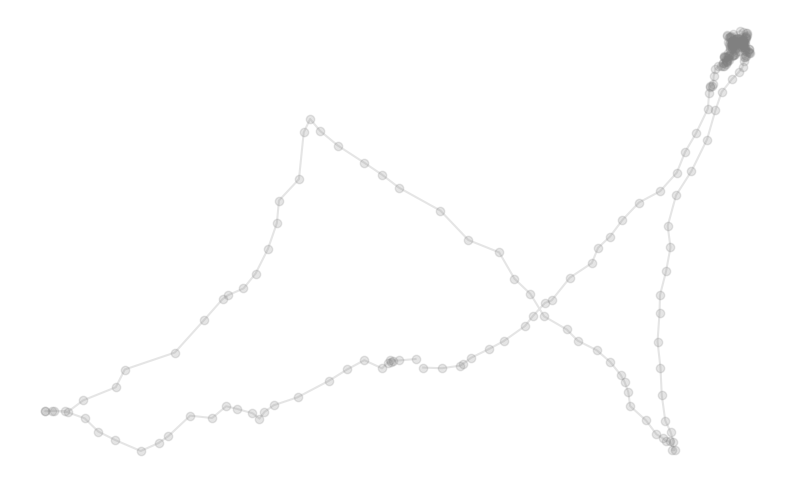

In [76]:
# plot the nose coordinates, line plot
# x_data = trial_df_keys[body_part, 'x']
# y_data = trial_df_keys[body_part, 'y']
port_data = {'time': port_times, 'port': port_numbers}
print(port_data)

time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# print(time_data)

# make the first time point 0
time_data = time_data - time_data[0]
# print(time_data)
# convert time_data to seconds considering the frame rate 60fps
time_data_seconds = time_data / 60

# get the x, y co-ordinates for the port times
port_x = np.interp(port_times, time_data_seconds, x_data)
port_y = np.interp(port_times, time_data_seconds, y_data)
# print(port_x, port_y)

# if stim_time exists, get the x, y co-ordinates for the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    
    print(stim_time)

    stim_x = np.interp(stim_time, time_data_seconds, x_data)
    stim_y = np.interp(stim_time, time_data_seconds, y_data)
    print(stim_x, stim_y)

# colour the first and last points differently in a gradient
colour = np.linspace(0, 1, len(x_data))


plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(x_data, y_data, marker='o', color='grey', alpha=0.2)
# plot the port events
# for i, port in enumerate(port_numbers):
#     plt.scatter(x=port_x[i], y=port_y[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    plt.scatter(x=stim_x, y=stim_y, c='cyan', label='stim', s=300, marker='*',edgecolors='black', linewidths=1)

# plt.title(f'Coordinates of {body_part}')
# invert the y axis
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
# plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
# remove axis
plt.axis('off')
plt.show()


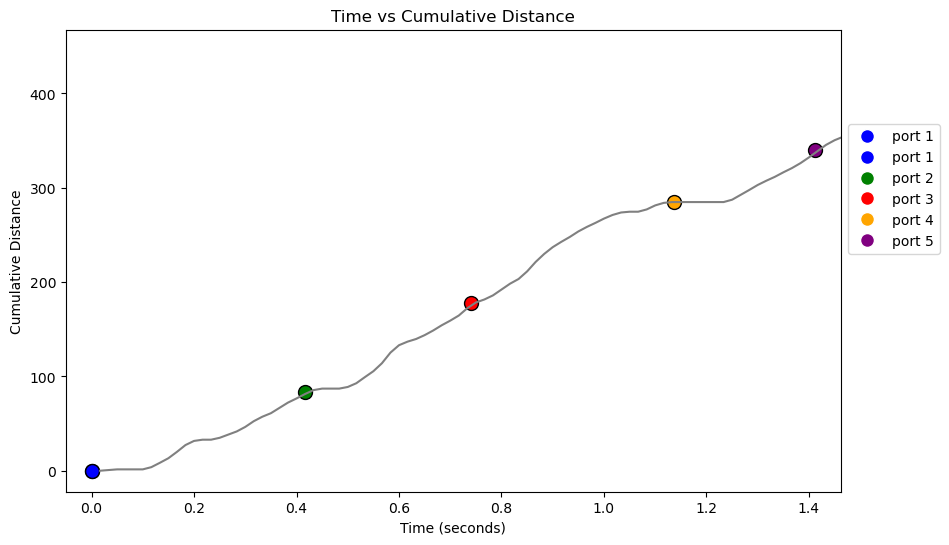

In [77]:
# linearize the x-data and y-data
# plot time vs x and y

time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# print(time_data)

# make the first time point 0
time_data = time_data - time_data[0]
# print(time_data)
# convert time_data to seconds considering the frame rate 60fps
time_data_seconds = time_data / 60
# print(time_data_seconds)

port_times = trimmed_trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
# print(port_times)
# Assuming x_data and y_data are already defined as numpy arrays or need to be converted
x_data = np.array(x_data) if not isinstance(x_data, np.ndarray) else x_data
y_data = np.array(y_data) if not isinstance(y_data, np.ndarray) else y_data

# Define a threshold and window size
threshold_distance = 5 # Example threshold, adjust as needed
window_size = 2 # Example window size, adjust as needed

# Calculate raw distances between points
raw_distances = np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2)
# Initialize an array for smoothed distances
smoothed_distances = np.zeros_like(raw_distances)

# Apply a moving window to calculate the sum of distances within the window and apply the threshold
for i in range(len(raw_distances)):
    # Calculate the sum of distances within the window
    window_sum = np.sum(raw_distances[max(0, i-window_size+1):i+1])
    # If the sum exceeds the threshold, count it towards the cumulative distance
    if window_sum > threshold_distance:
        smoothed_distances[i] = raw_distances[i]

# Calculate cumulative distance with the thresholded, smoothed distances
cumulative_distance = np.insert(np.cumsum(smoothed_distances), 0, 0)

# Interpolate the cumulative distance at the port times so that they fall on the same line as the x and y data
cumulative_distance_port = np.interp(port_times, time_data_seconds, cumulative_distance)
# if stim_port exists, get the cumulative distance at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_cumulative_distance = np.interp(stim_time, time_data_seconds, cumulative_distance)
    print(stim_cumulative_distance)
# smooth the cumulative distance
cumulative_distance = pd.Series(cumulative_distance).rolling(window=2).mean().to_numpy()



# Now, plot the cumulative distance over time
plt.figure(figsize=(10, 6))

# Plotting the cumulative distance against time
plt.plot(time_data_seconds, cumulative_distance, label='Cumulative Distance', color='grey')
# Plotting the cumulative distance against time for the port events
for i, port in enumerate(port_numbers):
    plt.scatter(port_times[i], cumulative_distance_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    # draw a vertical cyan line at the stim_cumulative_distance
    plt.axvline(x=stim_time, color='cyan', linestyle='--', label='stim')
plt.title('Time vs Cumulative Distance')
plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Distance')
# shortcut to not show the time aftre the last poke
plt.xlim(-0.05, port_times[-1] + 0.05)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

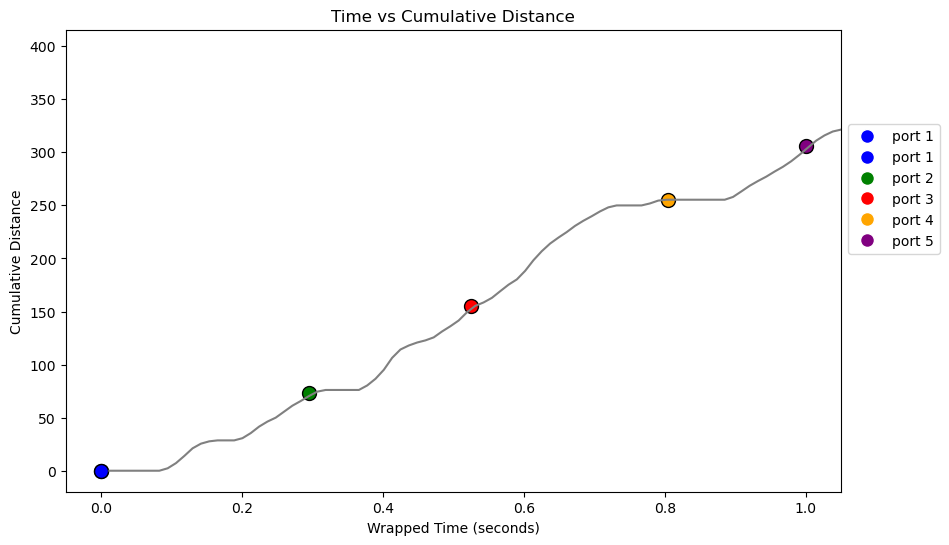

In [78]:
# plot the same as above but with time wrapped to become 0 to 1 
port_times = trimmed_trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
port_times_wrapped = (port_times - port_times[0]) / (port_times[-1] - port_times[0])

# Wrap time to 0-1, max value of time becomes 1 = port_times[-1] and first value becomes 0 and rest are scaled accordingly
time_data_wrapped = (time_data_seconds - port_times[0]) / (port_times[-1] - port_times[0])
# print(time_data_wrapped)

# calculate x_data and y_data as above
x_data = np.array(x_data) if not isinstance(x_data, np.ndarray) else x_data
y_data = np.array(y_data) if not isinstance(y_data, np.ndarray) else y_data

# Define a threshold and window size
threshold_distance = 10  # Example threshold, adjust as needed
window_size = 3 # Example window size, adjust as needed

# Calculate raw distances between points
raw_distances = np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2)
# Initialize an array for smoothed distances
smoothed_distances = np.zeros_like(raw_distances)

# Apply a moving window to calculate the sum of distances within the window and apply the threshold

for i in range(len(raw_distances)):
    # Calculate the sum of distances within the window
    window_sum = np.sum(raw_distances[max(0, i-window_size+1):i+1])
    # If the sum exceeds the threshold, count it towards the cumulative distance
    if window_sum > threshold_distance:
        smoothed_distances[i] = raw_distances[i]

# Calculate cumulative distance with the thresholded, smoothed distances
cumulative_distance = np.insert(np.cumsum(smoothed_distances), 0, 0)

# Interpolate the cumulative distance at the port times so that they fall on the same line as the x and y data
cumulative_distance_port = np.interp(port_times_wrapped, time_data_wrapped, cumulative_distance)


# if stim_port exists, get the cumulative distance at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_time = (stim_time - port_times[0]) / (port_times[-1] - port_times[0])
    stim_cumulative_distance = np.interp(stim_time, time_data_wrapped, cumulative_distance)
    print(stim_cumulative_distance)
    
# smooth the cumulative distance
cumulative_distance = pd.Series(cumulative_distance).rolling(window=2).mean().to_numpy()



# Now, plot the cumulative distance over time
plt.figure(figsize=(10, 6))

# Plotting the cumulative distance against time
plt.plot(time_data_wrapped, cumulative_distance, label='Cumulative Distance', color='grey')
# Plotting the cumulative distance against time for the port events
for i, port in enumerate(port_numbers):
    plt.scatter(port_times_wrapped[i], cumulative_distance_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    # draw a vertical cyan line at the stim_cumulative_distance
    plt.axvline(x=stim_time, color='cyan', linestyle='--', label='stim')

plt.title('Time vs Cumulative Distance')
plt.xlabel('Wrapped Time (seconds)')
plt.ylabel('Cumulative Distance')
# shortcut to not show the time aftre the last poke
plt.xlim(-0.05, 1.05)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

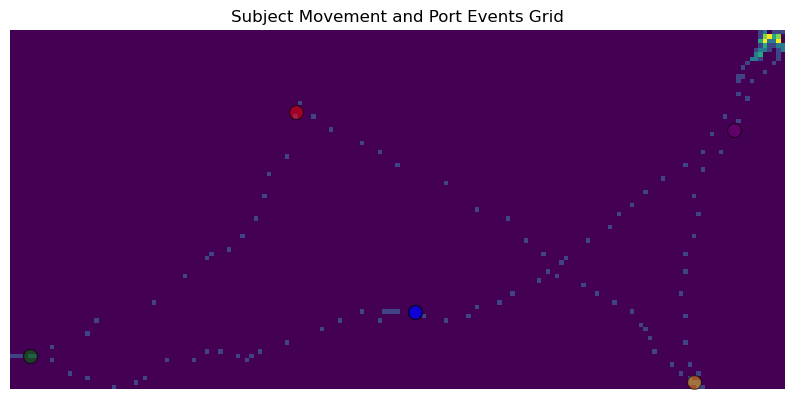

In [79]:
# Assume time_data_seconds, x_data, and y_data are defined

# Define grid size
grid_size_x = 1.0  # Adjust based on your data scale
grid_size_y = 1.0  # Adjust based on your data scale

# # Determine grid cell for each point
# grid_cells_x = np.floor(x_data / grid_size_x).astype(int)
# grid_cells_y = np.floor(y_data / grid_size_y).astype(int)
# For example, if your data starts from a large base value:
x_data_normalized = x_data - np.min(x_data)
y_data_normalized = y_data - np.min(y_data)

# Then recalculate grid cells with the normalized data
grid_cells_x = np.floor(x_data_normalized / grid_size_x).astype(int)
grid_cells_y = np.floor(y_data_normalized / grid_size_y).astype(int)
# Initialize a dictionary to track the time spent in each cell (keyed by cell coordinate)
time_spent_in_cells = {}

prev_cell = None
for i, time_second in enumerate(time_data_seconds):
    cell = (grid_cells_x[i], grid_cells_y[i])

    # Only increment time if the point has moved to a new cell
    if cell != prev_cell:
        if cell not in time_spent_in_cells:
            time_spent_in_cells[cell] = 0
        if i > 0:  # Avoid incrementing time for the first data point
            time_spent_in_cells[cell] += (time_second - time_data_seconds[i-1])
        prev_cell = cell

# Create a 2D array for the heatmap, dimensions based on max grid_cells_x and grid_cells_y
heatmap_data = np.zeros((max(grid_cells_x) + 1, max(grid_cells_y) + 1))
heatmap_data = heatmap_data.T

# Populate the heatmap data
for cell, time in time_spent_in_cells.items():
    heatmap_data[cell[1], cell[0]] = time

# get the x, y co-ordinates for the port times
port_x = np.interp(port_times, time_data_seconds, x_data)
port_x_normalized = port_x - np.min(x_data)
port_y = np.interp(port_times, time_data_seconds, y_data)
port_y_normalized = port_y - np.min(y_data)

# interpolate port times to the grid cells
port_x_grid = np.floor(port_x_normalized / grid_size_x).astype(int)
port_y_grid = np.floor(port_y_normalized / grid_size_y).astype(int)

# if stim_port exists, get the x, y co-ordinates for the stim_time

if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_x = np.interp(stim_time, time_data_seconds, x_data)
    stim_x_normalized = stim_x - np.min(x_data)
    stim_y = np.interp(stim_time, time_data_seconds, y_data)
    stim_y_normalized = stim_y - np.min(y_data)
    # interpolate stim time to the grid cells
    stim_x_grid = np.floor(stim_x_normalized / grid_size_x).astype(int)
    stim_y_grid = np.floor(stim_y_normalized / grid_size_y).astype(int)
# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest', origin='lower', vmax=np.max(heatmap_data) * 0.7)
# plt.colorbar(label='Time Spent in Cell')

# Ensure this uses the normalized and correctly scaled grid cell positions
for i, port in enumerate(port_numbers):
    plt.scatter(port_x_grid[i], port_y_grid[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1, alpha=0.5)

if stim_port:
    plt.scatter(stim_x_grid, stim_y_grid, c='cyan', label='stim', s=300, marker='*',edgecolors='black', linewidths=1)
plt.title('Subject Movement and Port Events Grid')
plt.xlabel('Grid Cell X Coordinate')
plt.ylabel('Grid Cell Y Coordinate')
# invert the y axis
plt.gca().invert_yaxis()
# axis off to remove the axis labels
plt.axis('off')
# no color bar
plt.colorbar().remove()
plt.show()

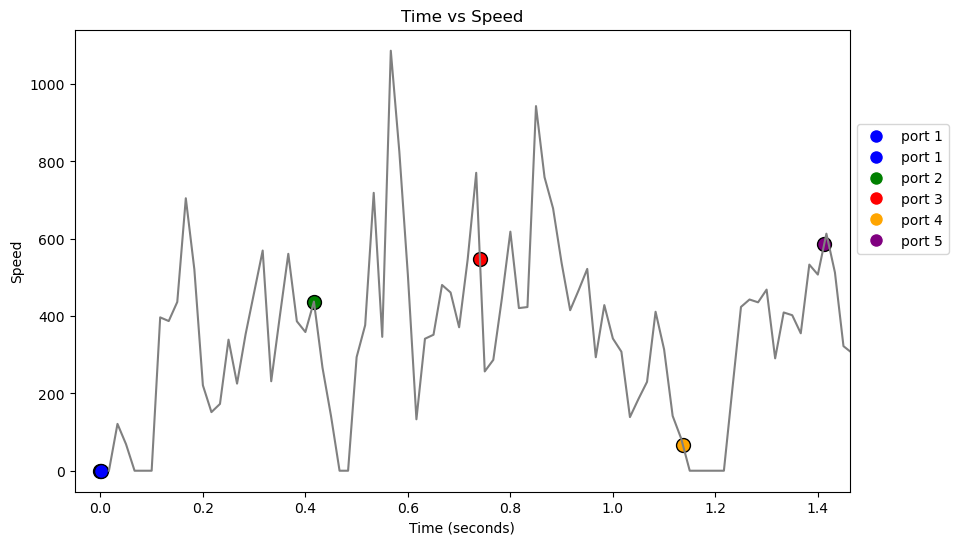

In [80]:
# linearize the x-data and y-data
# plot time vs x and y

time_data = trial_df_keys.index.get_level_values(0).to_numpy()
# print(time_data)

# make the first time point 0
time_data = time_data - time_data[0]
# print(time_data)
# convert time_data to seconds considering the frame rate 60fps
time_data_seconds = time_data / 60
# print(time_data_seconds)

port_times = trimmed_trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
# print(port_times)
# Assuming x_data and y_data are already defined as numpy arrays or need to be converted
x_data = np.array(x_data) if not isinstance(x_data, np.ndarray) else x_data
y_data = np.array(y_data) if not isinstance(y_data, np.ndarray) else y_data

# Define a threshold and window size
threshold_distance = 5  # Example threshold, adjust as needed
window_size = 3 # Example window size, adjust as needed

# Calculate raw distances between points
raw_distances = np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2)
# Initialize an array for smoothed distances
smoothed_distances = np.zeros_like(raw_distances)

# Apply a moving window to calculate the sum of distances within the window and apply the threshold

for i in range(len(raw_distances)):
    # Calculate the sum of distances within the window
    window_sum = np.sum(raw_distances[max(0, i-window_size+1):i+1])
    # If the sum exceeds the threshold, count it towards the cumulative distance
    if window_sum > threshold_distance:
        smoothed_distances[i] = raw_distances[i]

# Calculate cumulative distance with the thresholded, smoothed distances
cumulative_distance = np.insert(np.cumsum(smoothed_distances), 0, 0)

# now differentiate the cumulative distance to get the speed
speed = np.diff(cumulative_distance) / np.diff(time_data_wrapped)
# Interpolate the speed at the port times so that they fall on the same line as the x and y data
speed_port = np.interp(port_times, time_data_seconds[1:], speed)

# if stim_port exists, get the speed at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_speed = np.interp(stim_time, time_data_seconds[1:], speed)
    print(stim_speed)

    # now the aim is to find out the latency_to_pause and time_of_pause from the stim_time
    # get the speed at the stim_time

    
# smooth the speed
speed = pd.Series(speed).rolling(window=1).mean().to_numpy()


# Now, plot the speed over time
plt.figure(figsize=(10, 6))

# Plotting the speed against time
plt.plot(time_data_seconds[1:], speed, label='Speed', color='grey')
# Plotting the speed against time for the port events
for i, port in enumerate(port_numbers):
    plt.scatter(port_times[i], speed_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    # draw a vertical cyan line at the stim_speed
    plt.axvline(x=stim_time, color='cyan', linestyle='--', label='stim')
plt.title('Time vs Speed')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed')
# shortcut to not show the time aftre the last poke
plt.xlim(-0.05, port_times[-1]+0.05)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

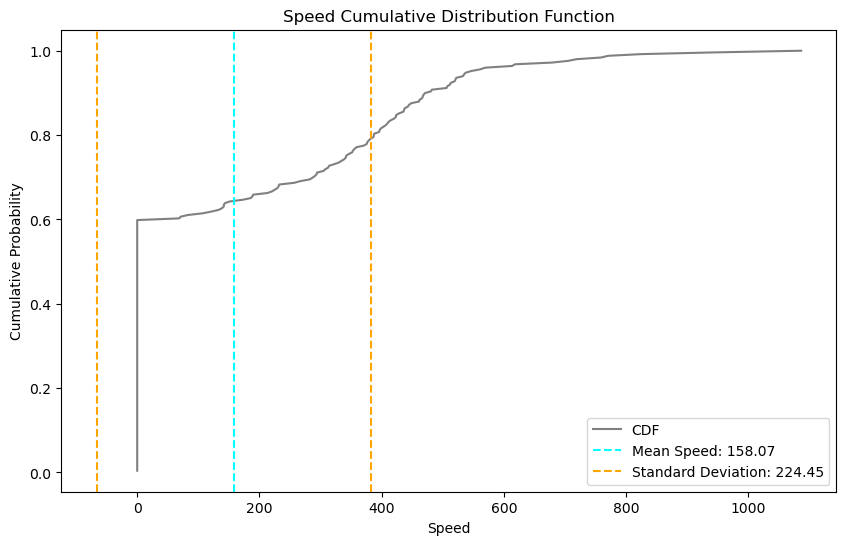

In [81]:
# Assuming `stim_time` and `speed` are already defined

# plot some statistics of the speed

# Calculate the mean and standard deviation of the speed
mean_speed = np.mean(speed)
std_speed = np.std(speed)

# Calculate the cumulative distribution function (CDF) of the speed
ecdf = ECDF(speed)

# Plot the CDF of the speed
plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y, label='CDF', color='grey')
# Plot the mean and standard deviation lines
plt.axvline(mean_speed, color='cyan', linestyle='--', label=f'Mean Speed: {mean_speed:.2f}')
plt.axvline(mean_speed - std_speed, color='orange', linestyle='--', label=f'Standard Deviation: {std_speed:.2f}')
plt.axvline(mean_speed + std_speed, color='orange', linestyle='--')
plt.title('Speed Cumulative Distribution Function')
plt.xlabel('Speed')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

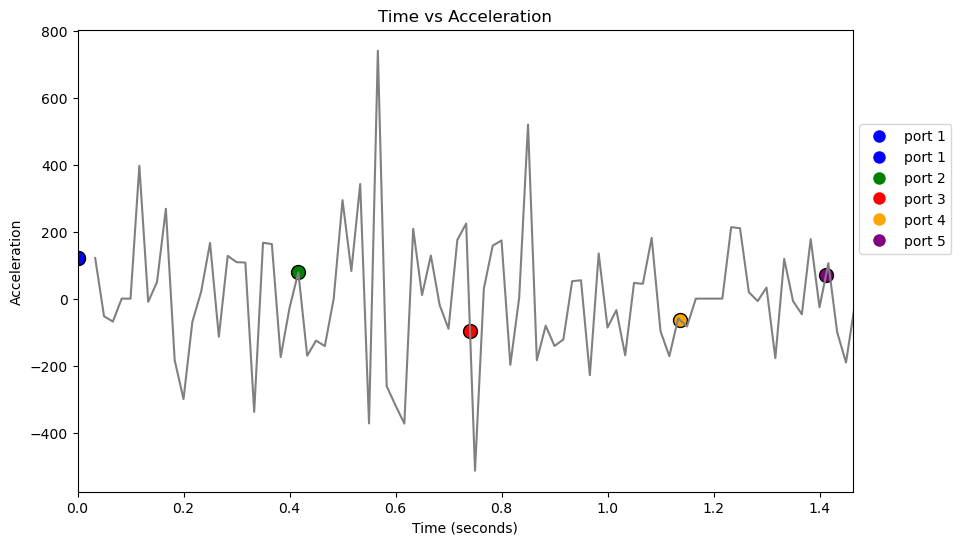

In [82]:
# plot acceleration
# calculate acceleration
acceleration = np.diff(speed) / np.diff(time_data[1:])
# Interpolate the acceleration at the port times so that they fall on the same line as the x and y data
acceleration_port = np.interp(port_times, time_data_seconds[2:], acceleration)
# if stim_port exists, get the acceleration at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_acceleration = np.interp(stim_time, time_data_seconds[2:], acceleration)
    print(stim_acceleration)
# smooth the acceleration
acceleration = pd.Series(acceleration).rolling(window=1).mean().to_numpy()

# Now, plot the acceleration over time
plt.figure(figsize=(10, 6))

# Plotting the acceleration against time
plt.plot(time_data_seconds[2:], acceleration, label='Acceleration', color='grey')
# Plotting the acceleration against time for the port events
for i, port in enumerate(port_numbers):
    plt.scatter(port_times[i], acceleration_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    plt.scatter(stim_time, stim_acceleration, c='cyan', label='stim', s=300, marker='*',edgecolors='black', linewidths=1)
plt.title('Time vs Acceleration')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration')
# shortcut to not show the time aftre the last poke
plt.xlim(0, port_times[-1]+0.05)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

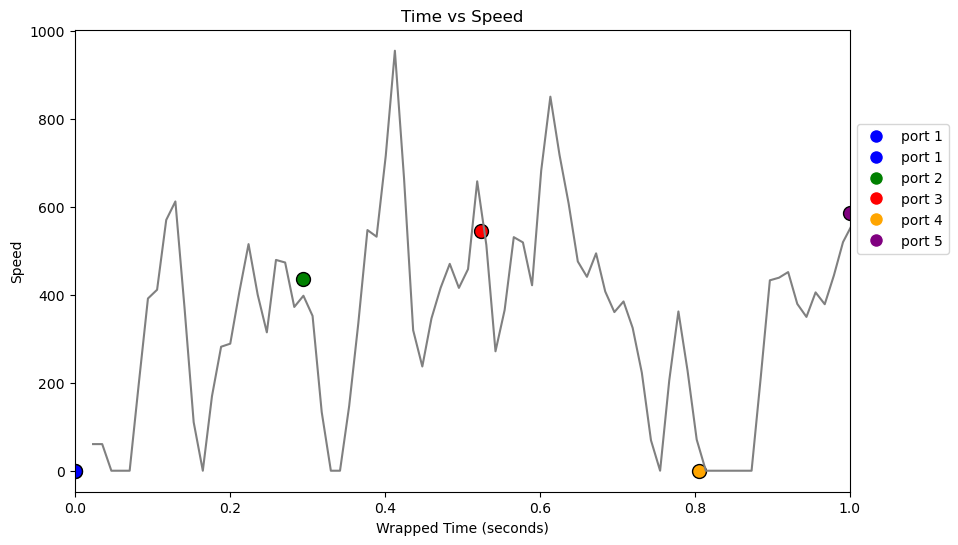

In [83]:
# plot the same as above but with time wrapped to become 0 to 1 
port_times = trimmed_trial_df['start_poke_in_timestamp'].values
port_times = port_times - port_times[0]
port_times_wrapped = (port_times - port_times[0]) / (port_times[-1] - port_times[0])

# Wrap time to 0-1, max value of time becomes 1 = port_times[-1] and first value becomes 0 and rest are scaled accordingly
time_data_wrapped = (time_data_seconds - port_times[0]) / (port_times[-1] - port_times[0])
# print(time_data_wrapped)

# calculate x_data and y_data as above
x_data = np.array(x_data) if not isinstance(x_data, np.ndarray) else x_data
y_data = np.array(y_data) if not isinstance(y_data, np.ndarray) else y_data

# Define a threshold and window size
threshold_distance = 5  # Example threshold, adjust as needed
window_size = 2 # Example window size, adjust as needed

# Calculate raw distances between points
raw_distances = np.sqrt(np.diff(x_data)**2 + np.diff(y_data)**2)
# Initialize an array for smoothed distances
smoothed_distances = np.zeros_like(raw_distances)

# Apply a moving window to calculate the sum of distances within the window and apply the threshold

for i in range(len(raw_distances)):
    # Calculate the sum of distances within the window
    window_sum = np.sum(raw_distances[max(0, i-window_size+1):i+1])
    # If the sum exceeds the threshold, count it towards the cumulative distance
    if window_sum > threshold_distance:
        smoothed_distances[i] = raw_distances[i]

# Calculate cumulative distance with the thresholded, smoothed distances
cumulative_distance = np.insert(np.cumsum(smoothed_distances), 0, 0)

# now differentiate the cumulative distance to get the speed
speed = np.diff(cumulative_distance) / np.diff(time_data_wrapped)
# Interpolate the speed at the port times so that they fall on the same line as the x and y data
speed_port = np.interp(port_times_wrapped, time_data_wrapped[1:], speed)

# if stim_port exists, get the speed at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_time = (stim_time - port_times[0]) / (port_times[-1] - port_times[0])
    stim_speed = np.interp(stim_time, time_data_wrapped[1:], speed)
    print(stim_speed)

# smooth the speed
speed = pd.Series(speed).rolling(window=2).mean().to_numpy()

# Now, plot the speed over time
plt.figure(figsize=(10, 6))

# Plotting the speed against time
plt.plot(time_data_wrapped[1:], speed, label='Speed', color='grey')
# Plotting the speed against time for the port events
for i, port in enumerate(port_numbers):
    plt.scatter(port_times_wrapped[i], speed_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    plt.scatter(stim_time, stim_speed, c='cyan', label='stim', s=300, marker='*',edgecolors='black', linewidths=1)
plt.title('Time vs Speed')
plt.xlabel('Wrapped Time (seconds)')
plt.ylabel('Speed')
# shortcut to not show the time aftre the last poke
plt.xlim(0, 1)
# plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
# show legend outside the plot
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

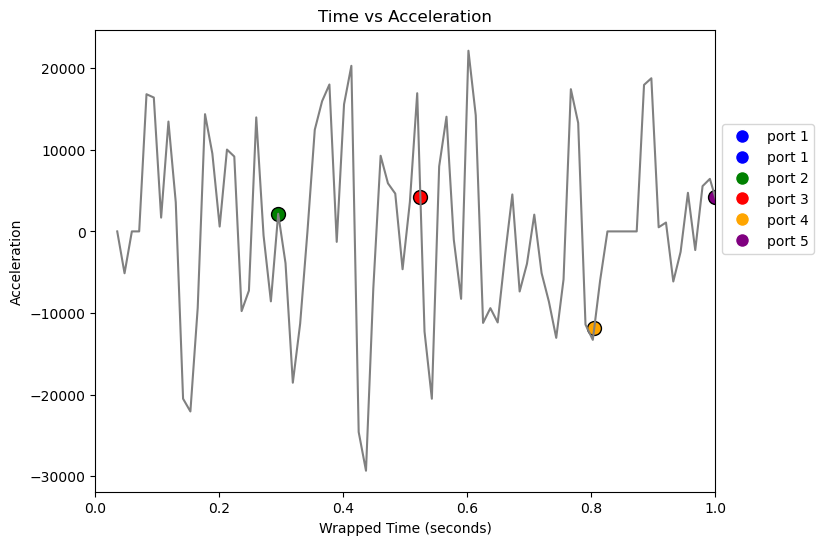

In [84]:
# plot acceleration over time

# calculate the acceleration
acceleration = np.diff(speed) / np.diff(time_data_wrapped[1:])
# Interpolate the acceleration at the port times so that they fall on the same line as the x and y data

acceleration_port = np.interp(port_times_wrapped, time_data_wrapped[2:], acceleration)

# if stim_port exists, get the acceleration at the stim_time
if stim_port:
    # stim_time = port_times at which port_number == stim_port first occurs
    stim_time = port_times[port_numbers == stim_port][0]
    stim_time = (stim_time - port_times[0]) / (port_times[-1] - port_times[0])
    stim_acceleration = np.interp(stim_time, time_data_wrapped[2:], acceleration)
    print(stim_acceleration)

# smooth the acceleration
acceleration = pd.Series(acceleration).rolling(window=1).mean().to_numpy()


# Plotting the acceleration over time
plt.figure(figsize=(8, 6))

# Plotting the acceleration against time
plt.plot(time_data_wrapped[2:], acceleration, label='Acceleration', color='grey')

# Find the minimum length to safely iterate without going out of bounds
min_length = min(len(port_times_wrapped), len(acceleration_port))

# Plotting the acceleration against time for the port events, ensuring we do not go out of bounds
for i in range(min_length):
    port = port_numbers[i]  # Adjust this if port_numbers length is different
    plt.scatter(port_times_wrapped[i], acceleration_port[i], c=port_colors[port], label=port_dict[port], s=100, edgecolors='black', linewidths=1)

if stim_port:
    plt.scatter(stim_time, stim_acceleration, c='cyan', label='stim', s=300, marker='*',edgecolors='black', linewidths=1)

plt.title('Time vs Acceleration')
plt.xlabel('Wrapped Time (seconds)')
plt.ylabel('Acceleration')
plt.xlim(0, 1)

# Plot legends of port colours, just one legend for each port
legend_elements = [Line2D([0], [0], marker='o', color='w', label=port_dict[port], markerfacecolor=port_colors[port], markersize=10) for port in port_numbers]
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()